# Probabilistic forecasting I: Temperature

Trabajo realizado por Alberto Cano Turnes y Alejandro Glozman

Enlace a la competición de Kaggle: https://www.kaggle.com/competitions/probabilistic-forecasting-i-temperature

En este trabajo, se nos pide a partir de unos datos proporcionados en la competición de Kaggle, realizar forecasting de temperaturas. Este forecasting debe estar formado por un conjunto de predicciones de cuantiles correspondientes a los siguientes intervalos de predicción simétricos: coberturas del 10, 20, 30, 40, 50, 60, 70, 80, 90 y 95%, junto con el cuantil "cobertura cero" 0.5, es decir, el pronóstico del punto medio.

Para realizar esta tarea, se nos ha proporcionado los siguientes datos:

    - train.csv: Contiene 64320 filas de datos en los que se encuentran 6 columnas con variables anónimas, una columna con variables time-stamp desde 2016-07-01 a 2018-05-01, una columna con IDs y las temperaturas correspondientes.
    - test.csv: Contiene 5360 filas en los que se encuentran 6 columnas con variables anónimas, una columna con variables time-stamp desde 2018-05-02 a 2018-06-26 y una columna con IDs.
    - sample_submission.csv: Sirve de template. Cuenta con una columna con IDs y 21 columnas con las predicciones de los siguientes cuantiles: 0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975.

En este trabajo nos encargaremos de realizar un EDA explorando los datos para ver que conclusiones llegamos a sacar y realizaremos un modelo para realizar el forecasting de las temperaturas y poder superar el baseline prestablecido.

In [154]:
QUANTILE_LEVELS = [0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975]

## Instalación de las librerías
Se recomienda el uso de un entorno virtual.

In [155]:
!pip install -r requirements.txt

## Importamos las librerías

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.sarimax import SARIMAX

from scipy.stats import t
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

## Importamos los datos, parseamos la columna date y comprobamos si hay datos faltantes

In [ ]:
train = pd.read_csv('./data/train.csv', index_col='date', parse_dates=['date'])
test = pd.read_csv('./data/test.csv', index_col='date', parse_dates=['date'])
template = pd.read_csv('./data/sample_submission.csv')

train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

train_features = train.columns.tolist()
test_features = test.columns.tolist()

if not train.isna().any().any():
    print('No hay datos faltantes en train.')
if not test.isna().any().any():
    print('No hay datos faltantes en test.')
    
print(f"Train shape: {train.shape}   test shape: {test.shape}")

No hay datos faltantes en train.
No hay datos faltantes en test.
Train shape: (64320, 7)   test shape: (5360, 6)


## Limpieza

Podemos observar que parece que no hay datos faltantes. Aun así, vamos a comprobar en el caso de que todas las columnas para una misma fila tomen el valor de 0, ya que eso podría contar como datos faltantes.

In [158]:
print(train[(train[test_features] == 0).all(axis=1)])

                     feature_AA  feature_AB  feature_BA  feature_BB  \
date                                                                  
2016-12-05 08:30:00         0.0         0.0         0.0         0.0   
2016-12-05 08:45:00         0.0         0.0         0.0         0.0   
2016-12-05 09:00:00         0.0         0.0         0.0         0.0   
2016-12-05 09:15:00         0.0         0.0         0.0         0.0   
2016-12-05 09:30:00         0.0         0.0         0.0         0.0   
...                         ...         ...         ...         ...   
2016-12-07 17:45:00         0.0         0.0         0.0         0.0   
2016-12-07 18:00:00         0.0         0.0         0.0         0.0   
2016-12-07 18:15:00         0.0         0.0         0.0         0.0   
2016-12-07 18:30:00         0.0         0.0         0.0         0.0   
2016-12-07 18:45:00         0.0         0.0         0.0         0.0   

                     feature_CA  feature_CB  Temperature  
date             

In [159]:
print(test[(test[test_features] == 0).all(axis=1)])

Empty DataFrame
Columns: [feature_AA, feature_AB, feature_BA, feature_BB, feature_CA, feature_CB]
Index: []


Se ve que desde el 05-12-2016 a las 8:30 hasta el 07-12-2016 a las 18:45 (234 filas) hubo algún problema y se dejaron de registrar las features. Usaremos una media rodante para rellenar estos datos faltantes.

In [160]:
def fill_data_rolling_mean(data, features, date_start_gap, date_end_gap):
    data.loc[date_start_gap:date_end_gap, features] = pd.NA
    rolling_mean = train[features].rolling(window=1000, min_periods=1).mean()
    data.loc[date_start_gap:date_end_gap, features] = data.loc[date_start_gap:date_end_gap, features].fillna(rolling_mean)

    return data

In [161]:
train = fill_data_rolling_mean(train, train_features, "2016-12-05 08:30:00", "2016-12-07 18:45:00 ")

In [162]:
pd.set_option('display.max_rows', 20)
train.iloc[15106:15340]

,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
date,,,,,,,
2016-12-05 08:30:00,9.917929,3.746785,7.124136,2.371563,2.723814,0.848521,13.025238
2016-12-05 08:45:00,9.919142,3.747653,7.124403,2.371945,2.724681,0.848883,13.030465
2016-12-05 09:00:00,9.920760,3.747852,7.124919,2.371936,2.725551,0.849153,13.036408
2016-12-05 09:15:00,9.921441,3.748050,7.124687,2.371927,2.726360,0.849302,13.042505
2016-12-05 09:30:00,9.923132,3.748519,7.125133,2.372025,2.727172,0.849513,13.048826
...,...,...,...,...,...,...,...
2016-12-07 17:45:00,9.892070,3.733032,7.074455,2.321222,2.753057,0.883622,14.345477
2016-12-07 18:00:00,9.888211,3.731789,7.070808,2.319112,2.753112,0.883939,14.347482
2016-12-07 18:15:00,9.889749,3.730630,7.071686,2.318661,2.753365,0.884257,14.349859


In [163]:
print(train[(train[test_features] == pd.NA).all(axis=1)])

Empty DataFrame
Columns: [feature_AA, feature_AB, feature_BA, feature_BB, feature_CA, feature_CB, Temperature]
Index: []


Observamos que ya no nos quedan filas vacías, por lo que continuamos con el EDA.

## EDA

A continuación realizaremos el análisis exploratorio de los datos.

In [164]:
train.head()

,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [165]:
test.head()

,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB
date,,,,,,
2018-05-02 00:00:00,14.133,2.076,9.346,-0.036,4.538,1.279
2018-05-02 00:15:00,12.123,1.541,7.818,-0.746,4.538,1.249
2018-05-02 00:30:00,12.525,1.741,8.209,-0.284,4.477,1.279
2018-05-02 00:45:00,12.324,1.942,7.747,0.249,4.630,1.371
2018-05-02 01:00:00,14.602,1.407,9.630,-0.320,4.477,1.310


In [166]:
train.describe()

,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
count,64320.000000,64320.000000,64320.000000,64320.000000,64320.000000,64320.000000,64320.000000
mean,7.558646,2.156548,4.504625,0.828954,3.052469,0.822496,13.655786
std,6.901411,2.021603,6.665464,1.820466,1.155326,0.600253,8.791429
min,-21.568001,-5.693000,-23.986000,-6.041000,-1.188000,-1.371000,-3.728000
25%,6.028000,0.670000,3.589000,-0.391000,2.284000,0.670000,6.824000
50%,8.908000,2.143000,6.076000,0.853000,2.802000,0.944000,12.029000
75%,11.721000,3.617000,8.635000,2.168000,3.594000,1.157000,18.712000
max,24.180000,10.315000,18.087000,7.853000,8.498000,3.046000,46.007000


In [167]:
test.describe()

,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,6.111379,3.683676,2.444574,1.810346,3.567110,1.320451
std,8.750415,1.687125,8.292539,1.363704,1.116847,0.319568
min,-23.242001,-2.210000,-26.367001,-3.411000,1.097000,0.000000
25%,1.942000,2.545000,-1.173000,1.031000,2.650000,1.097000
50%,8.306000,3.818000,5.046000,1.954000,3.137000,1.340000
75%,12.994000,4.957000,8.742000,2.807000,4.538000,1.523000
max,19.490999,7.837000,13.788000,5.010000,6.183000,2.863000


In [168]:
train.dtypes

feature_AA     float64
feature_AB     float64
feature_BA     float64
feature_BB     float64
feature_CA     float64
feature_CB     float64
Temperature    float64
dtype: object

In [169]:
test.dtypes

feature_AA    float64
feature_AB    float64
feature_BA    float64
feature_BB    float64
feature_CA    float64
feature_CB    float64
dtype: object

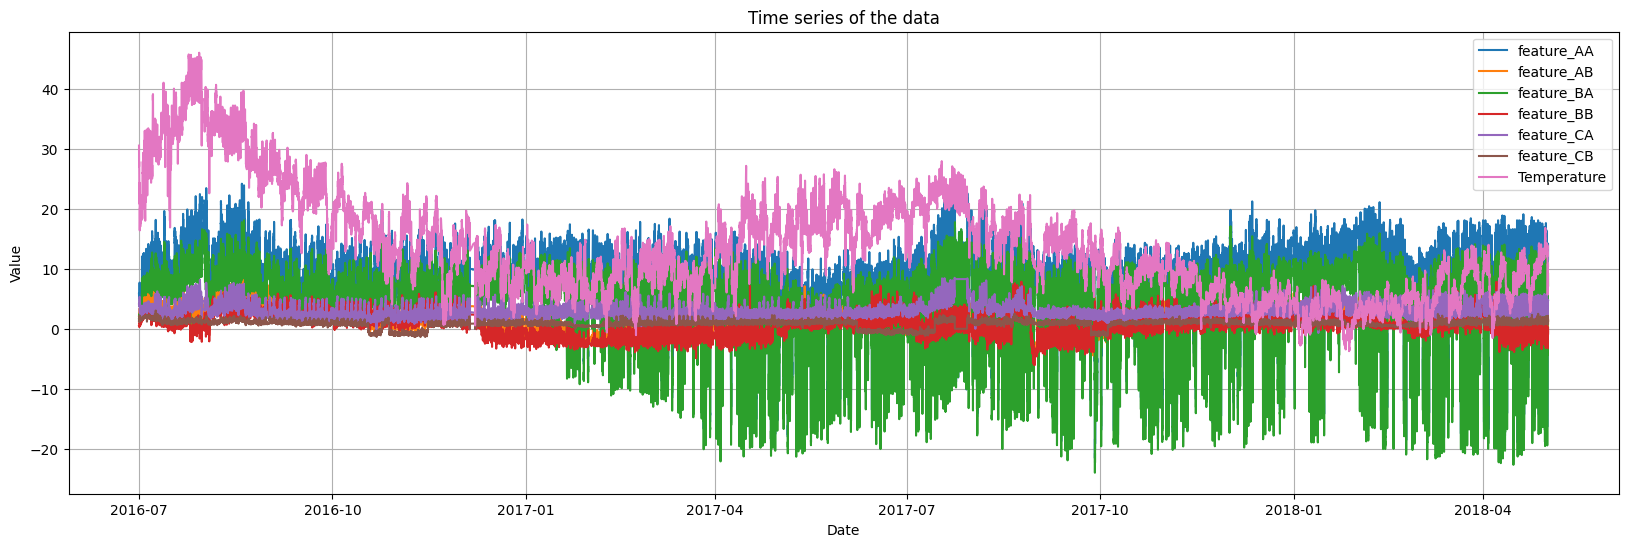

In [170]:
plt.figure(figsize=(20, 6))
for feature in train_features:
    plt.plot(train.index, train[feature], label=feature)
    
plt.title('Time series of the data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Se observa que en Julio - Octubre de 2016 la temperatura fue muy elevado comparada con los mismos meses de los años posteriores.

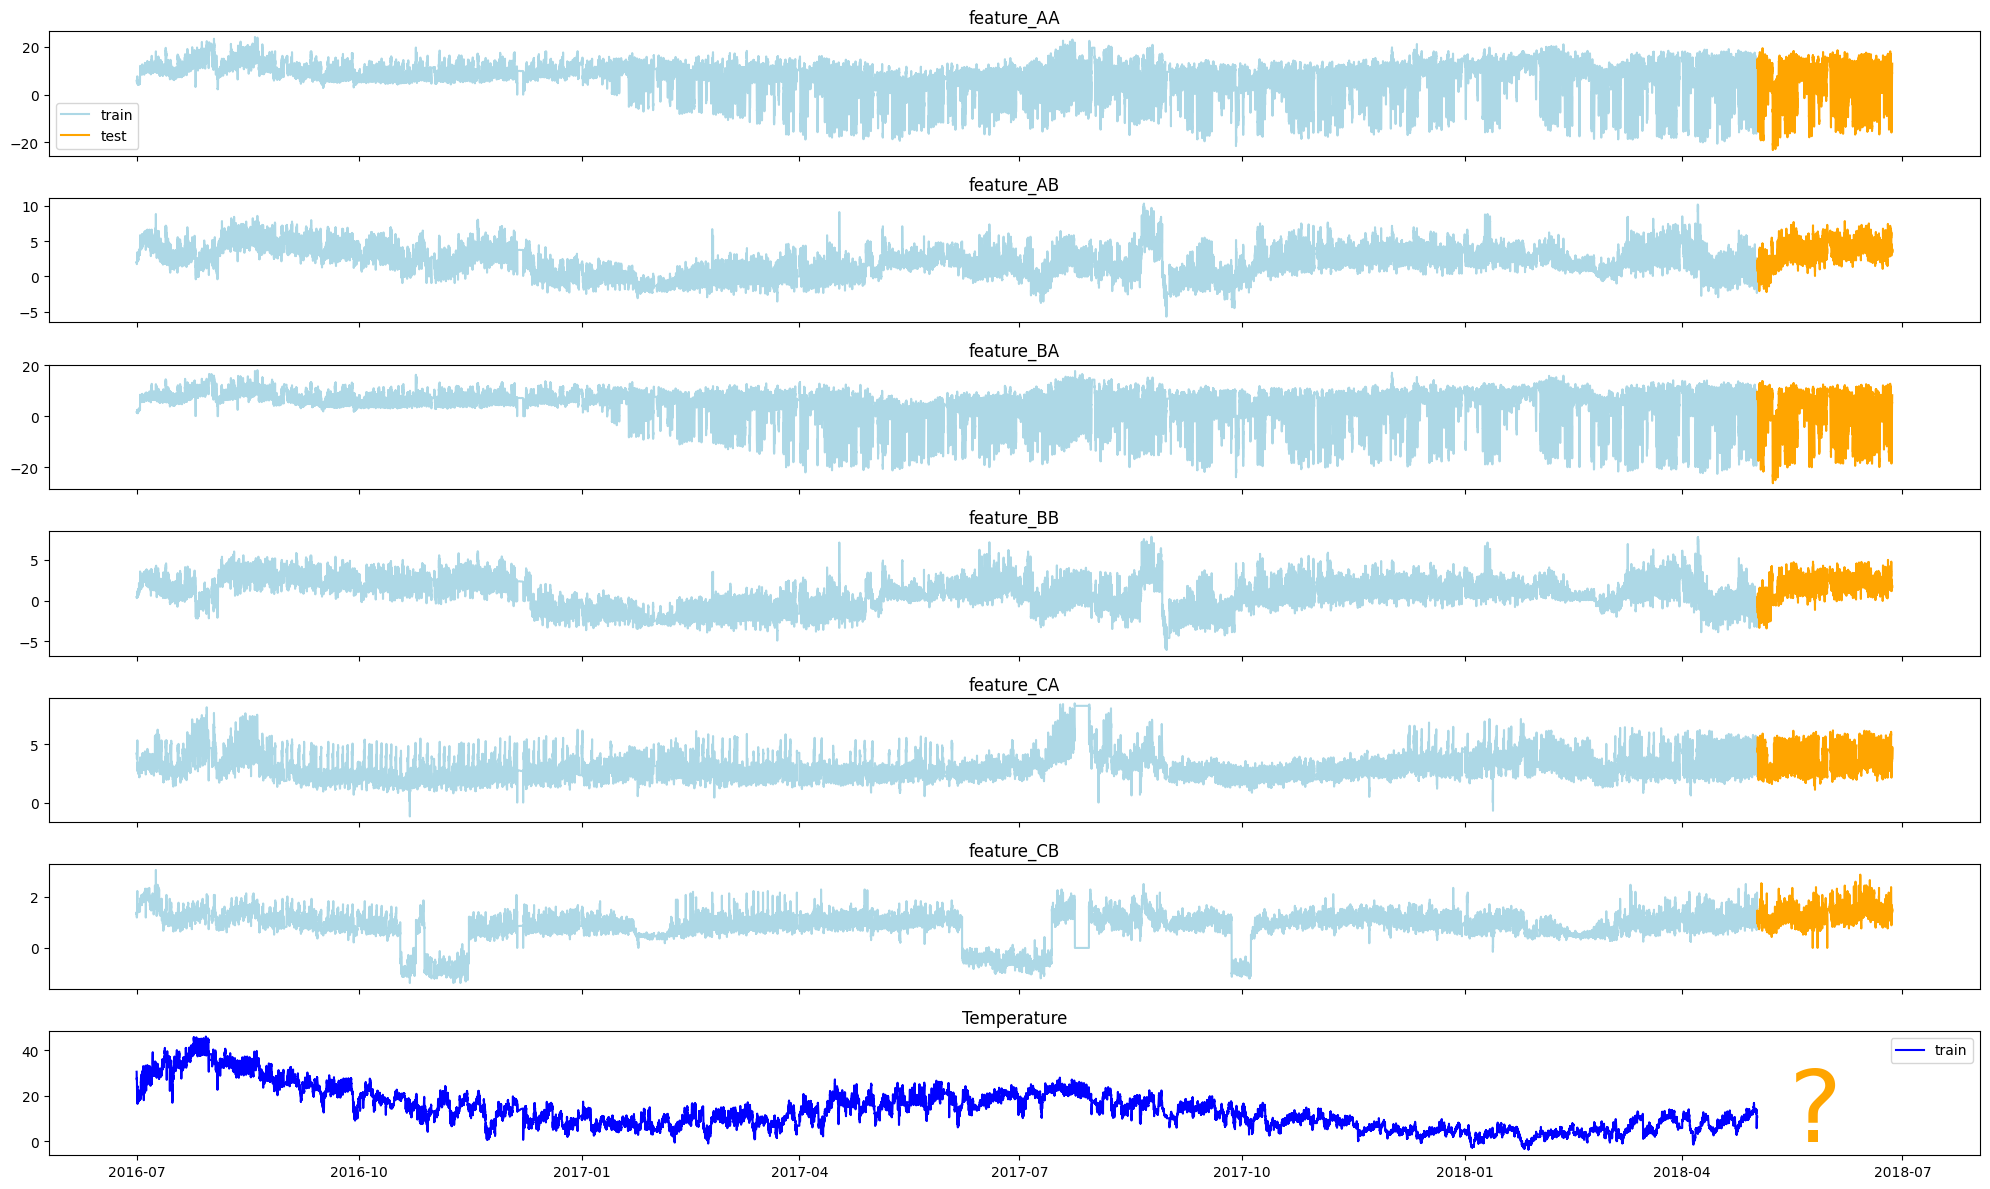

In [171]:
_, axs = plt.subplots(7, 1, sharex=True, figsize=(20, 12))
for ax, col in zip(axs, train_features + ['Temperature']):
    ax.set_title(col)
    ax.plot(train.index, train[col], label='train', color='lightblue' if col != 'Temperature' else 'b')
    if col != 'Temperature':
        ax.plot(test.index, test[col], label='test', color='orange')
    else:
        ax.text(pd.to_datetime('2018-05-15'), 0, '?', fontsize=72, color='orange')
    if col in ['feature_AA', 'Temperature']:
        ax.legend()
plt.tight_layout()
plt.show()

Al observar las series temporales de cada columna, podemos llegar a las siguientes conclusiones:

    - Las features AA y BA parecen estar correlacionadas.
    - Las features AB y BB también parecen estar correlacionadas.
    - En los meses de verano la temperatura es más alta, por lo que hay estacionalidad.

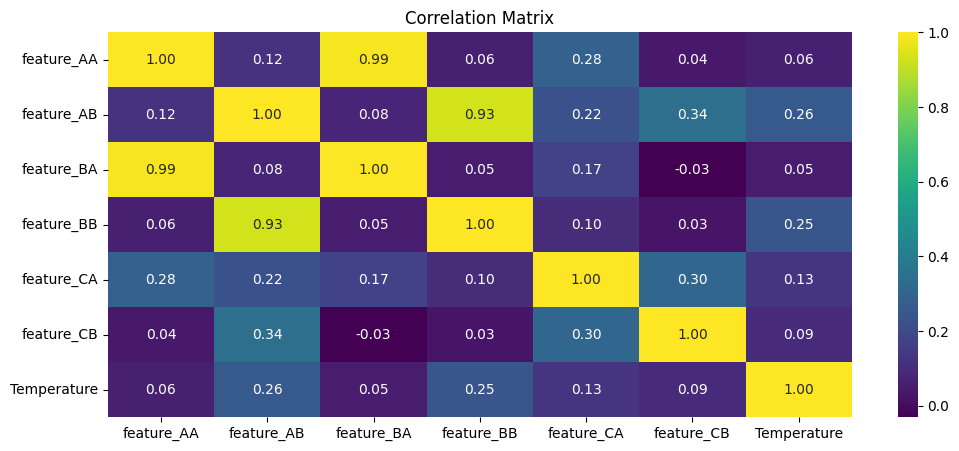

In [172]:
corr_matrix = train.corr()
plt.figure(figsize=(12,5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Efectivamente, las features mencionadas anteriormente tienen un alto índice de correlación.

In [173]:
def ad_test(data):
  dftest = adfuller(data, autolag = "AIC")
  print("1. ADF: ", dftest[0])
  print("2. P-Value: ", dftest[1])
  print("3. Num of Lags: ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation: ", dftest[3])
  print("5. Critical Values: ")

  for key, val in dftest[4].items():
    print("\t", key, ": ", val)

In [174]:
ad_test(train['Temperature'])

1. ADF:  -3.94889713672571
2. P-Value:  0.001703053768711277
3. Num of Lags:  61
4. Num Of Observations Used For ADF Regression and Critical Values Calculation:  64258
5. Critical Values: 
	 1% :  -3.4304517703826356
	 5% :  -2.861584980638992
	 10% :  -2.5667939416681875


Tenemos un p-valor inferior a 0.05, por lo que podemos determinar que la serie temporal es estacionaria. Podemos aplicar modelos de ARIMA y SARIMA posteriormente.

In [175]:
def Forecasting_Temperature(df, share_type='num_sold', samples=500, period=24):
    if samples == 'all':
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    fig, axs = plt.subplots(4, figsize=(20,18))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    axs[3].set_title('NOISE', fontsize=10)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

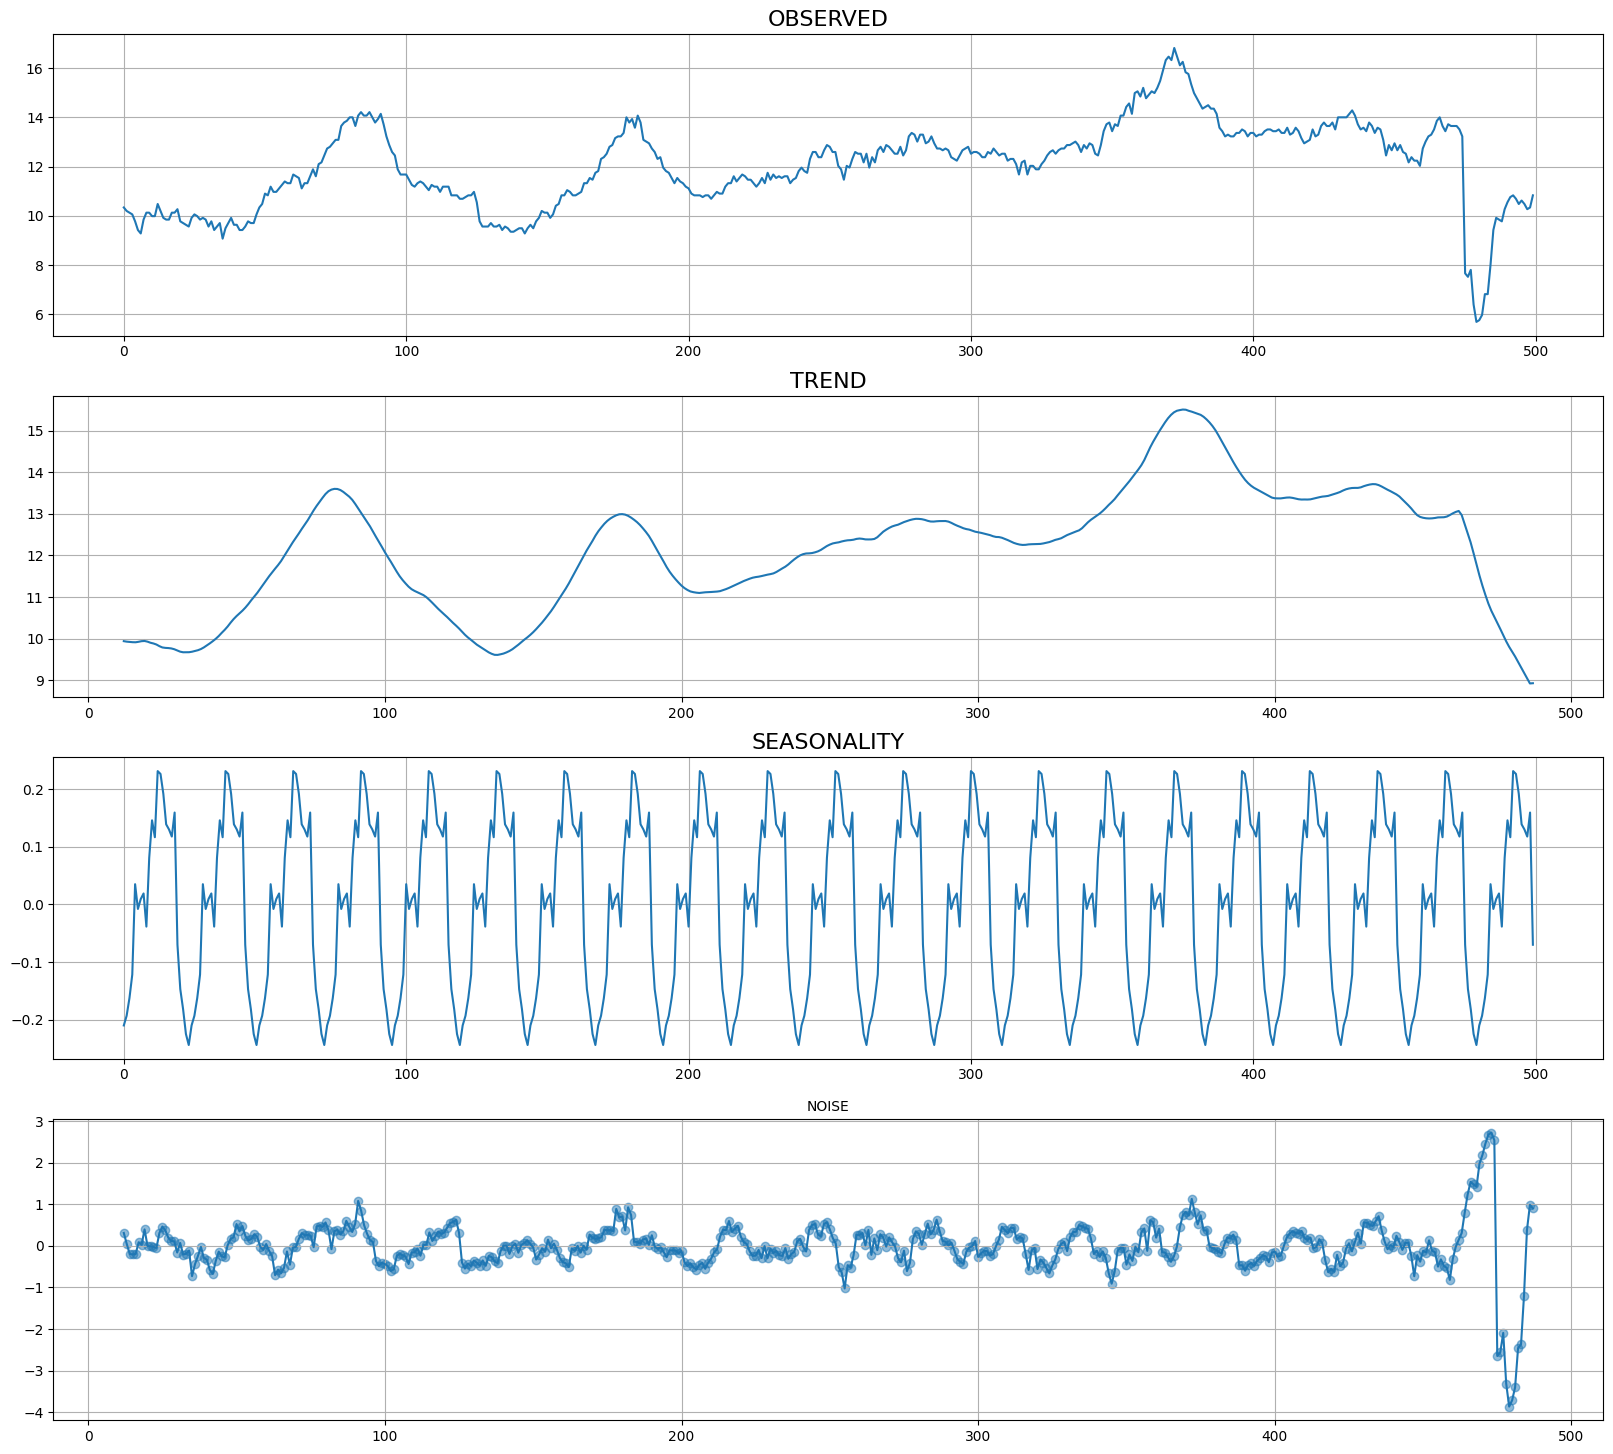

In [176]:
Forecasting_Temperature(train, share_type='Temperature', samples=500, period=24)


Podemos llegar a algunas conclusiones viendo estas gráficas:

    - Vemos que la tendencia se repite de forma creciente y decreciente.
    - Observamos que nuestra serie temporal tiene un componente estacional con una frecuencia de 12 meses, lo que a grandes rasgos significa que el patrón periódico se repite cada 25 ventanas.

## Feature Engineering

Vamos a crear nuevas variables a partir de la columna date. Estas nuevas columnas pueden ayudar a la hora de realizar el forecasting. Para ello, vamos a desglosar el índice que tiene formato datetime y vamos a obtener las siguientes variables:

    - week_of_year
    - day_of_week
    - year
    - month
    - day
    - hour
    - minute

In [177]:
def preprocess(df):
    df['week_of_year'] = df.index.map(lambda x: x.isocalendar()[1])
    df['day_of_week'] = df.index.dayofweek
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute

    return df

In [178]:
train = preprocess(train)
test = preprocess(test)

In [179]:
train.head()

,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature,week_of_year,day_of_week,year,month,day,hour,minute
date,,,,,,,,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,26,4,2016,7,1,0,0
2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999,26,4,2016,7,1,0,15
2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000,26,4,2016,7,1,0,30
2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000,26,4,2016,7,1,0,45
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,26,4,2016,7,1,1,0


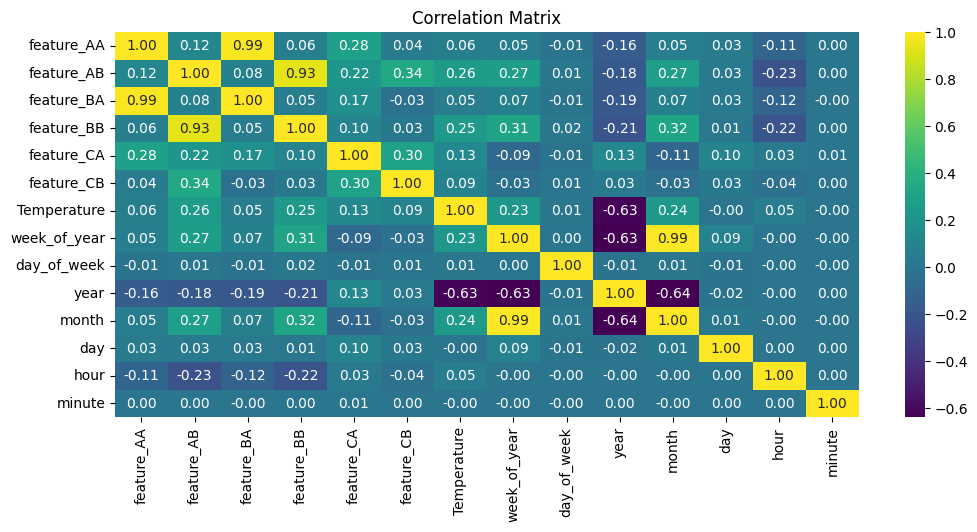

In [180]:
corr_matrix = train.corr()
plt.figure(figsize=(12,5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

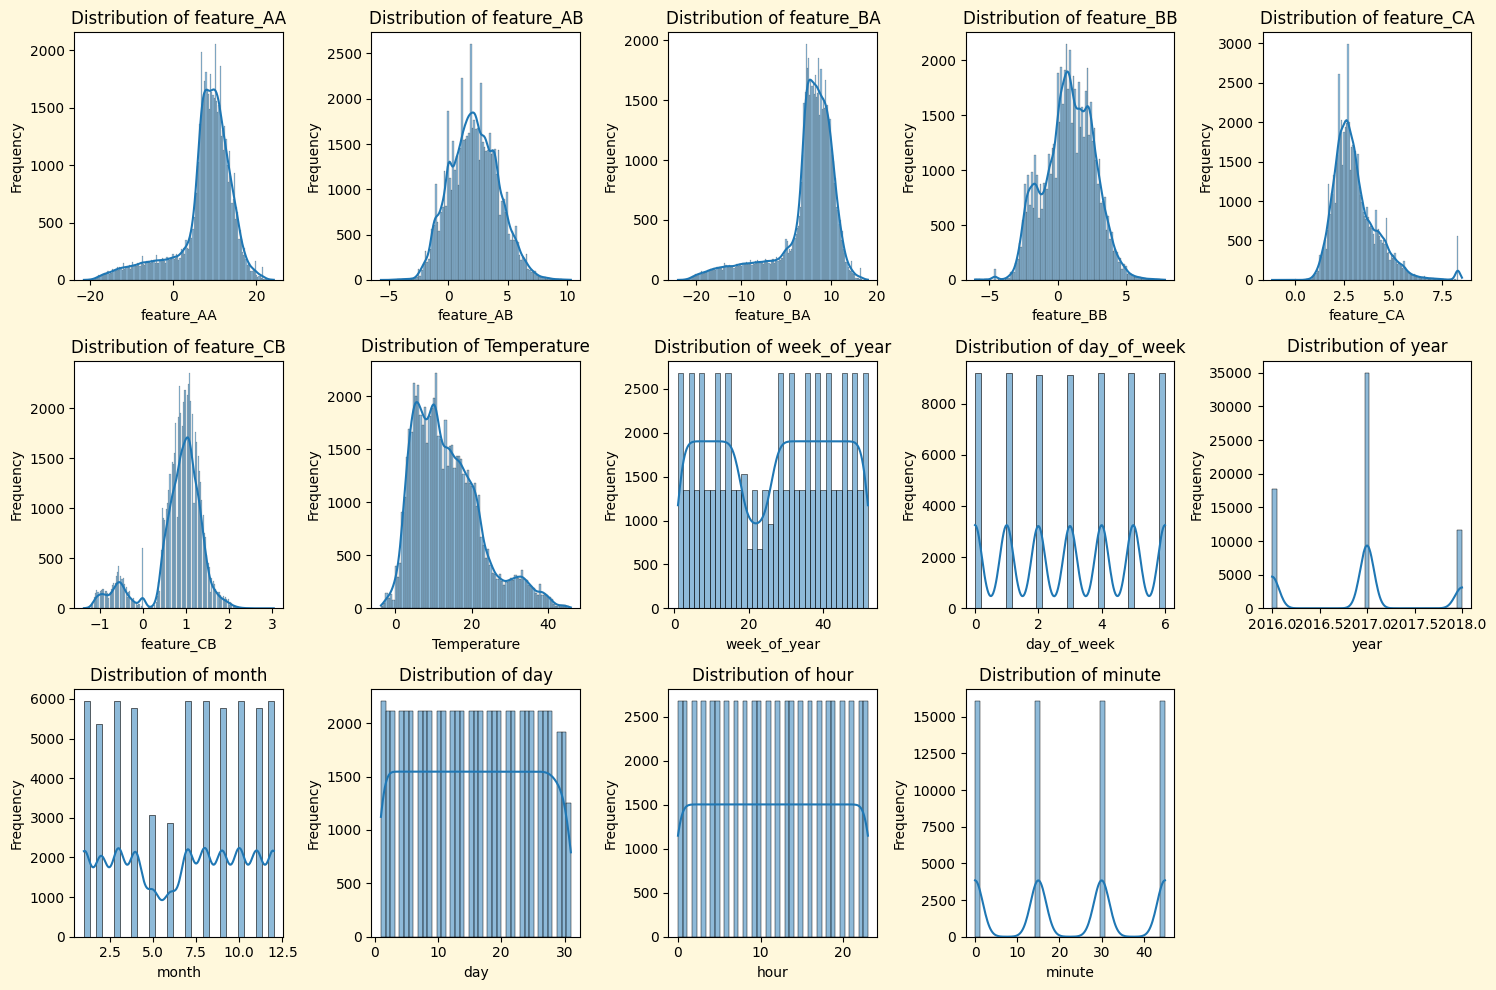

In [181]:
train_features = train.columns.tolist()

num_plots = len(train_features)
rows = 3
cols = math.ceil(num_plots / rows)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

for i, feature in enumerate(train_features):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    sns.histplot(train[feature], kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

for i in range(num_plots, rows * cols):
    row = i // cols
    col = i % cols
    fig.delaxes(axes[row, col])

plt.gcf().set_facecolor('#FFF8DC') 
plt.tight_layout()
plt.show()

## Modelos de forecasting

A continuación plantearemos diferentes modelos para poder resolver este problema junto a los resultados obtenidos después de subirlos a Kaggle. El baseline está en 9.7089.

## XGBoost Regressor
Score obtenido en Kaggle: 2.3316

Vamos a probar con un regresor XGBoost Regressor usando 1000 estimadores y todo el dataset de train para el entrenamiento.

In [182]:
X_train = train.drop('Temperature', axis=1)
y_train = train['Temperature']

X_test = test

In [183]:
model = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha=QUANTILE_LEVELS, n_estimators=1000)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:quantileerror', ...)

In [184]:
predictions = model.predict(X_test)
predictions

array([[ 7.5221987,  8.155425 , 10.230661 , ..., 13.485026 , 12.939926 ,
        13.332606 ],
       [ 6.9140496,  8.434411 ,  8.931003 , ..., 12.484253 , 13.1273775,
        13.247872 ],
       [ 7.126068 ,  8.226094 , 10.115309 , ..., 12.933492 , 12.808425 ,
        13.173037 ],
       ...,
       [13.133704 , 13.567446 , 14.86463  , ..., 13.2642975, 12.93405  ,
        13.993281 ],
       [13.702976 , 13.382648 , 15.652185 , ..., 13.206496 , 12.894827 ,
        13.807608 ],
       [13.915804 , 13.313041 , 16.361488 , ..., 12.857021 , 12.814096 ,
        13.605    ]], dtype=float32)

A continuación formateamos el dataframe para poder devolver un csv como en el que se nos pide en sample_submission.csv

In [185]:
predictions = pd.DataFrame(predictions, columns=QUANTILE_LEVELS)
predictions.insert(0, "id", template["id"].values)
predictions

,id,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975
0,64320,7.522199,8.155425,10.230661,9.987337,9.878007,7.270965,8.831071,10.253592,9.574313,...,12.255834,10.362536,11.516872,11.525226,11.794065,12.489990,12.716769,13.485026,12.939926,13.332606
1,64321,6.914050,8.434411,8.931003,9.166938,9.625854,7.220988,8.381865,9.402048,9.800903,...,11.828255,10.098488,10.499423,11.176665,11.065408,12.354220,12.089128,12.484253,13.127378,13.247872
2,64322,7.126068,8.226094,10.115309,9.482816,9.661958,7.220770,8.533794,9.586990,9.398802,...,12.351982,10.475684,10.421889,11.726768,11.476233,12.677376,12.470654,12.933492,12.808425,13.173037
3,64323,7.145646,8.087162,10.398347,9.438996,10.362648,7.494555,9.204594,10.585506,9.972076,...,12.367440,11.026304,11.005638,11.860563,11.650219,12.892029,12.690199,12.969625,12.832788,13.071046
4,64324,7.662804,8.408564,10.283525,9.842072,9.377206,7.618533,8.623755,9.664220,9.791627,...,12.298042,10.403913,10.366442,11.551212,10.628081,11.830714,12.855308,13.003865,12.860953,13.154191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675,13.535560,13.497004,15.216228,16.372089,14.762815,16.273758,15.379300,14.649454,13.892968,...,13.551987,14.910202,14.666676,14.287310,13.433077,13.840143,13.916509,13.823386,13.417925,14.329228
5356,69676,13.078300,13.414424,14.854473,16.195879,13.959360,15.988042,14.388822,14.627484,13.020714,...,13.119903,14.298526,13.699319,14.080498,12.973938,13.634867,13.976698,13.224598,13.069635,13.858251
5357,69677,13.133704,13.567446,14.864630,16.568949,14.548656,15.992753,14.438071,14.623902,12.965189,...,13.002254,14.500891,13.826637,13.855136,13.158728,13.830114,13.877040,13.264297,12.934050,13.993281
5358,69678,13.702976,13.382648,15.652185,16.153288,13.713031,16.331398,14.059592,14.680886,12.716863,...,13.017220,14.419350,13.403905,13.639066,13.675467,13.457916,13.769101,13.206496,12.894827,13.807608


In [186]:
predictions.to_csv('XGB_submission.csv')

Vamos a volver a formatear el dataframe pero esta vez para poder mostrarl los resultados en una gráfica

In [187]:
predictions.index = test.index
predictions = predictions.drop('id', axis=1)
predictions

,0.025,0.050,0.100,0.150,0.200,0.250,0.300,0.350,0.400,0.450,...,0.550,0.600,0.650,0.700,0.750,0.800,0.850,0.900,0.950,0.975
date,,,,,,,,,,,,,,,,,,,,,
2018-05-02 00:00:00,7.522199,8.155425,10.230661,9.987337,9.878007,7.270965,8.831071,10.253592,9.574313,10.966560,...,12.255834,10.362536,11.516872,11.525226,11.794065,12.489990,12.716769,13.485026,12.939926,13.332606
2018-05-02 00:15:00,6.914050,8.434411,8.931003,9.166938,9.625854,7.220988,8.381865,9.402048,9.800903,9.283798,...,11.828255,10.098488,10.499423,11.176665,11.065408,12.354220,12.089128,12.484253,13.127378,13.247872
2018-05-02 00:30:00,7.126068,8.226094,10.115309,9.482816,9.661958,7.220770,8.533794,9.586990,9.398802,9.768856,...,12.351982,10.475684,10.421889,11.726768,11.476233,12.677376,12.470654,12.933492,12.808425,13.173037
2018-05-02 00:45:00,7.145646,8.087162,10.398347,9.438996,10.362648,7.494555,9.204594,10.585506,9.972076,10.711699,...,12.367440,11.026304,11.005638,11.860563,11.650219,12.892029,12.690199,12.969625,12.832788,13.071046
2018-05-02 01:00:00,7.662804,8.408564,10.283525,9.842072,9.377206,7.618533,8.623755,9.664220,9.791627,9.877433,...,12.298042,10.403913,10.366442,11.551212,10.628081,11.830714,12.855308,13.003865,12.860953,13.154191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-26 18:45:00,13.535560,13.497004,15.216228,16.372089,14.762815,16.273758,15.379300,14.649454,13.892968,14.718473,...,13.551987,14.910202,14.666676,14.287310,13.433077,13.840143,13.916509,13.823386,13.417925,14.329228
2018-06-26 19:00:00,13.078300,13.414424,14.854473,16.195879,13.959360,15.988042,14.388822,14.627484,13.020714,13.765055,...,13.119903,14.298526,13.699319,14.080498,12.973938,13.634867,13.976698,13.224598,13.069635,13.858251
2018-06-26 19:15:00,13.133704,13.567446,14.864630,16.568949,14.548656,15.992753,14.438071,14.623902,12.965189,14.038297,...,13.002254,14.500891,13.826637,13.855136,13.158728,13.830114,13.877040,13.264297,12.934050,13.993281


Mostramos la mediana de la predicción

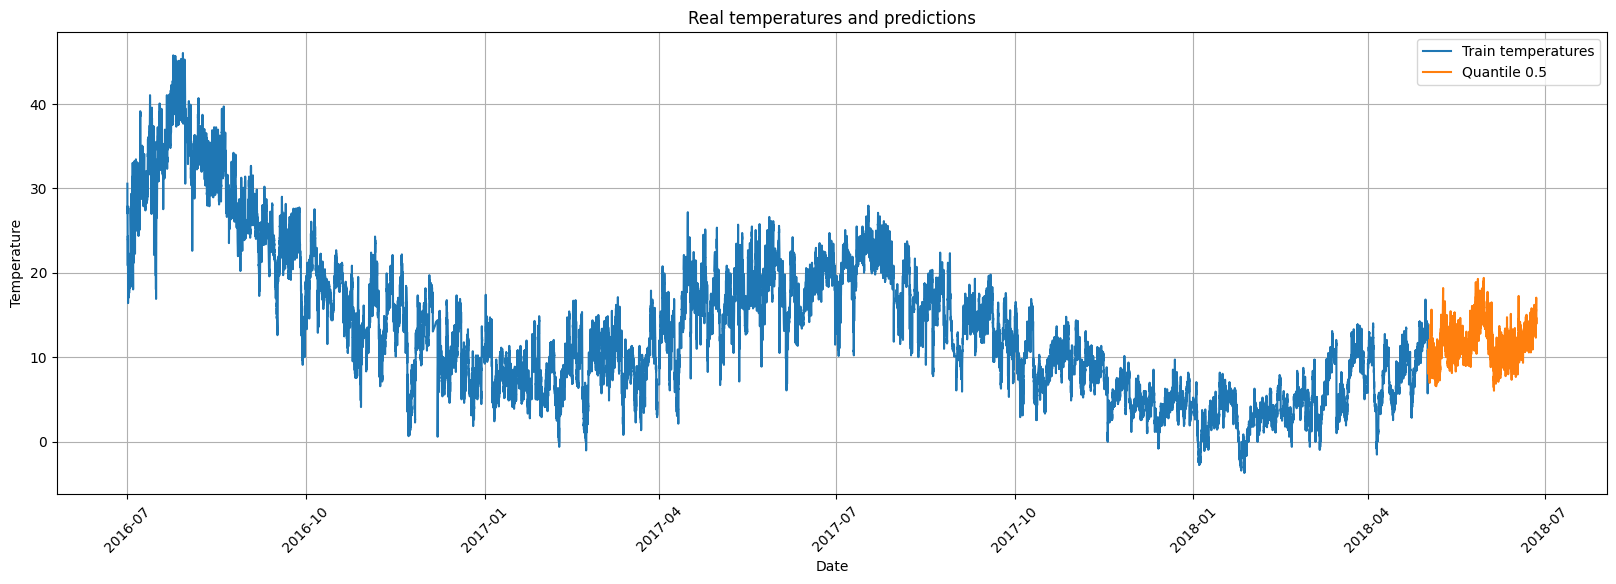

In [188]:
plt.figure(figsize=(20, 6))

sns.lineplot(data=train, x=train.index, y='Temperature', label='Train temperatures')

#for column in predictions.columns:
    #sns.lineplot(data=predictions, x=predictions.index, y=column, label=column)

sns.lineplot(data=predictions, x=predictions.index, y=predictions[0.5], label=f'Quantile {predictions.columns[10]}')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Real temperatures and predictions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Random Forest Regressor
Score obtenido en Kaggle: 2.7850

Vamos a probar con un regresor XGBoost Regressor usando 1000 arboles y todo el dataset de train para el entrenamiento.

In [189]:
X_train = train.drop('Temperature', axis=1)
y_train = train['Temperature']

X_test = test

In [190]:
model = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

In [191]:
y_test = [est.predict(X_test.values) for est in model.estimators_]
predictions = np.array(y_test)
predictions.shape  

(1000, 5360)

Calculamos los cuantiles y lo formateamos para que el dataframe tenga la forma que se nos pide en Kaggle

In [192]:
quantile_predictions = {"id": template.id}
quantile_predictions.update({q: None for q in QUANTILE_LEVELS})

for q in QUANTILE_LEVELS:
    quantile_predictions[q] = np.quantile(predictions, q, axis=0)
    
submission_df = pd.DataFrame.from_dict(quantile_predictions)
submission_df.head()

,id,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975
0,64320,13.085,13.296,13.296,13.366,13.366,13.366,13.366,13.366,13.436,...,13.507,13.577,13.577,13.577,13.577,13.577,13.577,13.577,13.577,13.577
1,64321,10.693,13.085,13.085,13.155,13.225,13.296,13.296,13.366,13.366,...,13.366,13.436,13.507,13.577,13.577,13.577,13.577,13.577,13.577,13.647
2,64322,12.944,13.085,13.225,13.225,13.296,13.366,13.366,13.366,13.366,...,13.366,13.366,13.366,13.366,13.507,13.577,13.577,13.577,13.577,13.577
3,64323,12.944,13.085,13.155,13.296,13.296,13.296,13.296,13.366,13.366,...,13.436,13.436,13.507,13.577,13.577,13.577,13.577,13.577,13.577,13.577
4,64324,12.944,13.085,13.296,13.366,13.366,13.366,13.366,13.366,13.366,...,13.507,13.507,13.507,13.577,13.577,13.577,13.577,13.577,13.577,13.647


In [193]:
submission_df.to_csv("RF_submission.csv", index=False)

Vamos a volver a formatear el dataframe pero esta vez para poder mostrar los resultados en una gráfica

In [194]:
submission_df.index = test.index
submission_df = submission_df.drop('id', axis=1)
submission_df

,0.025,0.050,0.100,0.150,0.200,0.250,0.300,0.350,0.400,0.450,...,0.550,0.600,0.650,0.700,0.750,0.800,0.850,0.900,0.950,0.975
date,,,,,,,,,,,,,,,,,,,,,
2018-05-02 00:00:00,13.085,13.2960,13.2960,13.366,13.366,13.366,13.366,13.366,13.436,13.436,...,13.507,13.5770,13.577,13.577,13.5770,13.577,13.577,13.577,13.577,13.577
2018-05-02 00:15:00,10.693,13.0850,13.0850,13.155,13.225,13.296,13.296,13.366,13.366,13.366,...,13.366,13.4360,13.507,13.577,13.5770,13.577,13.577,13.577,13.577,13.647
2018-05-02 00:30:00,12.944,13.0850,13.2250,13.225,13.296,13.366,13.366,13.366,13.366,13.366,...,13.366,13.3660,13.366,13.366,13.5070,13.577,13.577,13.577,13.577,13.577
2018-05-02 00:45:00,12.944,13.0850,13.1550,13.296,13.296,13.296,13.296,13.366,13.366,13.366,...,13.436,13.4360,13.507,13.577,13.5770,13.577,13.577,13.577,13.577,13.577
2018-05-02 01:00:00,12.944,13.0850,13.2960,13.366,13.366,13.366,13.366,13.366,13.366,13.436,...,13.507,13.5070,13.507,13.577,13.5770,13.577,13.577,13.577,13.577,13.647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-26 18:45:00,7.527,8.4420,9.8490,9.849,10.060,10.060,10.179,10.271,10.271,10.482,...,12.100,12.6484,13.225,13.296,13.2960,13.366,13.366,13.436,13.788,14.140
2018-06-26 19:00:00,7.527,8.0200,9.7499,9.849,9.905,10.060,10.130,10.271,10.271,10.341,...,11.256,12.3670,13.225,13.296,13.3660,13.366,13.436,13.507,13.788,14.140
2018-06-26 19:15:00,7.527,7.8790,9.2860,9.849,9.989,10.130,10.130,10.200,10.271,10.341,...,11.256,12.5500,13.225,13.225,13.2960,13.366,13.366,13.436,13.788,14.140


Mostramos la mediana de la predicción

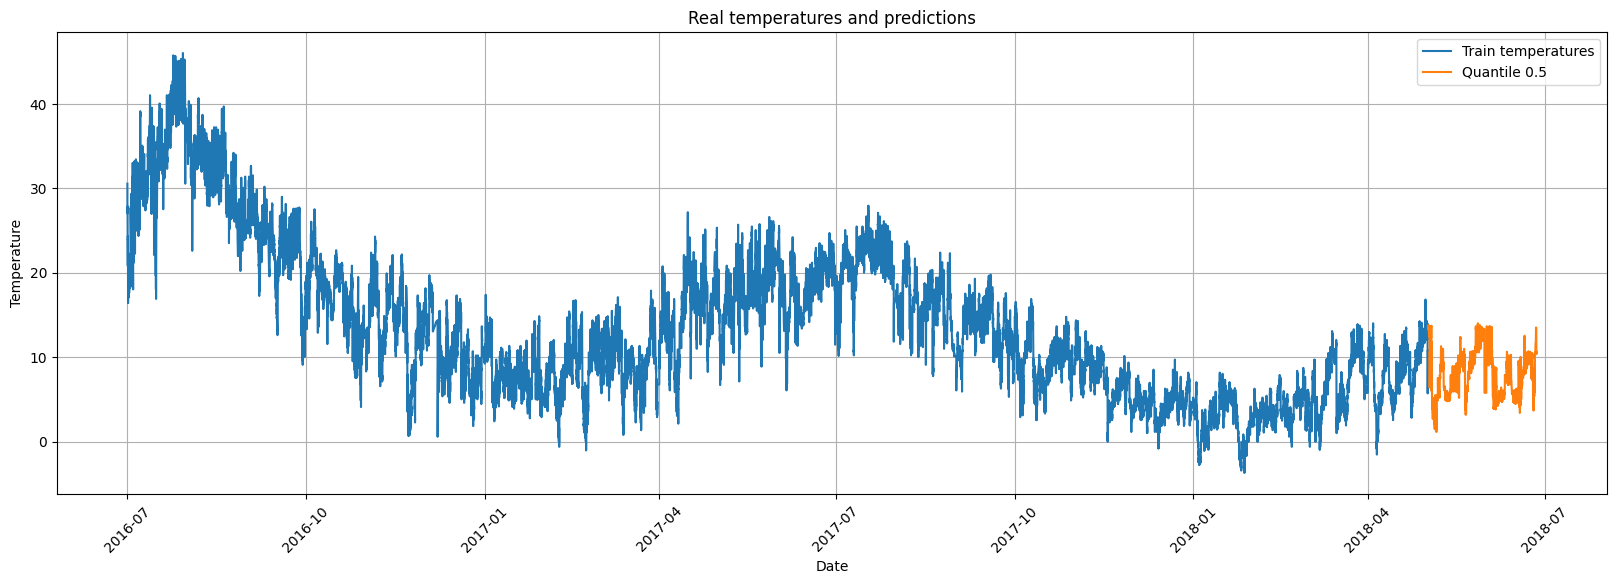

In [195]:
plt.figure(figsize=(20, 6))

sns.lineplot(data=train, x=train.index, y='Temperature', label='Train temperatures')

#for column in submission_df.columns:
    #sns.lineplot(data=submission_df, x=submission_df.index, y=column, label=column)

sns.lineplot(data=submission_df, x=submission_df.index, y=submission_df[0.5], label=f'Quantile {submission_df.columns[10]}')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Real temperatures and predictions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## ARIMA
Score obtenido en Kaggle: 2.1620

Dado a que obtuvimos un valor de p-value inferior a 0.05 en la prueba de ADF, podemos probar a usar modelos de ARIMA y SARIMA. Para ambos modelos, usaremos la columna temperatura como variable a predecir y e lresto de features los usaremos como características exogéneas que ayuden a mejorar la predicción obtenida

In [196]:
forecaster = AutoARIMA(trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, stationary=True)

In [197]:
train_no_temp = train.drop("Temperature", axis=1)

forecaster.fit(train["Temperature"], train_no_temp)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=82096.971, Time=88.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=453945.145, Time=21.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=63.34 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=372753.785, Time=68.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=453990.747, Time=78.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=82162.984, Time=78.82 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=82306.211, Time=71.93 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=82494.294, Time=90.24 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=82093.499, Time=92.79 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=81935.126, Time=89.75 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=267643.656, Time=90.74 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=82021.481, Time=104.90 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=314601.980, Time=79.03 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=233186.559, Time=98.77 sec
 ARI

AutoARIMA(error_action='ignore', stationary=True, suppress_warnings=True,
          trace=True)

In [198]:
test["Temperature"] = 0

In [199]:
X_test = test.drop("Temperature", axis=1)
y_test = test.index

In [200]:
predictions = forecaster.predict_quantiles(fh=y_test, X=X_test, alpha=QUANTILE_LEVELS)
predictions.head()

Temperature                                              \
                          0.025      0.050      0.100      0.150      0.200   
date                                                                          
2018-05-02 00:00:00    9.941291  10.085420  10.251591  10.363706  10.452812   
2018-05-02 00:15:00    9.508450   9.719832   9.963541  10.127971  10.258655   
2018-05-02 00:30:00    9.221844   9.480766   9.779287   9.980698  10.140772   
2018-05-02 00:45:00    9.005803   9.303384   9.646477   9.877959  10.061934   
2018-05-02 01:00:00    8.781532   9.113100   9.495377   9.753298   9.958285   

                                                                            \
                         0.250      0.300      0.350      0.400      0.450   
date                                                                         
2018-05-02 00:00:00  10.529257  10.597906  10.661520  10.721884  10.780287   
2018-05-02 00:15:00  10.370770  10.471453  10.564750  10.653280  10.738934   
2018-05-02 00:30:00  10.278102  10.401429  10.515709  10.624150  10.729068   
2018-05-02 00:45:00  10.219769  10.361509  10.492852  10.617484  10.738067   
2018-05-02 01:00:00  10.134146  10.292074  10.438418  10.577284  10.711639   

                     ...                                              \
                     ...      0.550      0.600      0.650      0.700   
date                 ...                                               
2018-05-02 00:00:00  ...  10.895240  10.953642  11.014006  11.077620   
2018-05-02 00:15:00  ...  10.907526  10.993180  11.081710  11.175008   
2018-05-02 00:30:00  ...  10.935577  11.040494  11.148935  11.263216   
2018-05-02 00:45:00  ...  10.975409  11.095991  11.220623  11.351967   
2018-05-02 01:00:00  ...  10.976088  11.110443  11.249309  11.395653   

                                                                            \
                         0.750      0.800      0.850      0.900      0.950   
date                                                                         
2018-05-02 00:00:00  11.146269  11.222714  11.311820  11.423935  11.590106   
2018-05-02 00:15:00  11.275691  11.387806  11.518489  11.682919  11.926629   
2018-05-02 00:30:00  11.386542  11.523872  11.683947  11.885357  12.183878   
2018-05-02 00:45:00  11.493707  11.651541  11.835516  12.066999  12.410091   
2018-05-02 01:00:00  11.553581  11.729442  11.934429  12.192349  12.574627   

                                
                         0.975  
date                            
2018-05-02 00:00:00  11.734235  
2018-05-02 00:15:00  12.138011  
2018-05-02 00:30:00  12.442801  
2018-05-02 00:45:00  12.707672  
2018-05-02 01:00:00  12.906195  

[5 rows x 21 columns]

A continuación formateamos el dataframe para poder devolver un csv como en el que se nos pide en sample_submission.csv

In [201]:
predictions.columns

MultiIndex([('Temperature', 0.025),
            ('Temperature',  0.05),
            ('Temperature',   0.1),
            ('Temperature',  0.15),
            ('Temperature',   0.2),
            ('Temperature',  0.25),
            ('Temperature',   0.3),
            ('Temperature',  0.35),
            ('Temperature',   0.4),
            ('Temperature',  0.45),
            ('Temperature',   0.5),
            ('Temperature',  0.55),
            ('Temperature',   0.6),
            ('Temperature',  0.65),
            ('Temperature',   0.7),
            ('Temperature',  0.75),
            ('Temperature',   0.8),
            ('Temperature',  0.85),
            ('Temperature',   0.9),
            ('Temperature',  0.95),
            ('Temperature', 0.975)],
           )

In [202]:
quantiles_columns = predictions.columns.droplevel(level=0)
predictions.columns = quantiles_columns
predictions.columns

Index([0.025,  0.05,   0.1,  0.15,   0.2,  0.25,   0.3,  0.35,   0.4,  0.45,
         0.5,  0.55,   0.6,  0.65,   0.7,  0.75,   0.8,  0.85,   0.9,  0.95,
       0.975],
      dtype='float64')

In [203]:
predictions["id"] = template["id"].values
id_column = predictions.pop('id')

predictions.insert(0, 'id', id_column)
predictions = predictions.reset_index(drop=True)
predictions.head()

,id,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975
0,64320,9.941291,10.085420,10.251591,10.363706,10.452812,10.529257,10.597906,10.661520,10.721884,...,10.895240,10.953642,11.014006,11.077620,11.146269,11.222714,11.311820,11.423935,11.590106,11.734235
1,64321,9.508450,9.719832,9.963541,10.127971,10.258655,10.370770,10.471453,10.564750,10.653280,...,10.907526,10.993180,11.081710,11.175008,11.275691,11.387806,11.518489,11.682919,11.926629,12.138011
2,64322,9.221844,9.480766,9.779287,9.980698,10.140772,10.278102,10.401429,10.515709,10.624150,...,10.935577,11.040494,11.148935,11.263216,11.386542,11.523872,11.683947,11.885357,12.183878,12.442801
3,64323,9.005803,9.303384,9.646477,9.877959,10.061934,10.219769,10.361509,10.492852,10.617484,...,10.975409,11.095991,11.220623,11.351967,11.493707,11.651541,11.835516,12.066999,12.410091,12.707672
4,64324,8.781532,9.113100,9.495377,9.753298,9.958285,10.134146,10.292074,10.438418,10.577284,...,10.976088,11.110443,11.249309,11.395653,11.553581,11.729442,11.934429,12.192349,12.574627,12.906195


In [204]:
predictions.to_csv("ARIMA_submission.csv", index=False)

Vamos a volver a formatear el dataframe pero esta vez para poder mostrar los resultados en una gráfica

In [205]:
predictions.index = test.index
predictions = predictions.drop('id', axis=1)
predictions

,0.025,0.050,0.100,0.150,0.200,0.250,0.300,0.350,0.400,0.450,...,0.550,0.600,0.650,0.700,0.750,0.800,0.850,0.900,0.950,0.975
date,,,,,,,,,,,,,,,,,,,,,
2018-05-02 00:00:00,9.941291,10.085420,10.251591,10.363706,10.452812,10.529257,10.597906,10.661520,10.721884,10.780287,...,10.895240,10.953642,11.014006,11.077620,11.146269,11.222714,11.311820,11.423935,11.590106,11.734235
2018-05-02 00:15:00,9.508450,9.719832,9.963541,10.127971,10.258655,10.370770,10.471453,10.564750,10.653280,10.738934,...,10.907526,10.993180,11.081710,11.175008,11.275691,11.387806,11.518489,11.682919,11.926629,12.138011
2018-05-02 00:30:00,9.221844,9.480766,9.779287,9.980698,10.140772,10.278102,10.401429,10.515709,10.624150,10.729068,...,10.935577,11.040494,11.148935,11.263216,11.386542,11.523872,11.683947,11.885357,12.183878,12.442801
2018-05-02 00:45:00,9.005803,9.303384,9.646477,9.877959,10.061934,10.219769,10.361509,10.492852,10.617484,10.738067,...,10.975409,11.095991,11.220623,11.351967,11.493707,11.651541,11.835516,12.066999,12.410091,12.707672
2018-05-02 01:00:00,8.781532,9.113100,9.495377,9.753298,9.958285,10.134146,10.292074,10.438418,10.577284,10.711639,...,10.976088,11.110443,11.249309,11.395653,11.553581,11.729442,11.934429,12.192349,12.574627,12.906195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-26 18:45:00,0.965553,2.863488,5.051684,6.528050,7.701419,8.708065,9.612065,10.449755,11.244641,12.013702,...,13.527438,14.296500,15.091386,15.929076,16.833075,17.839721,19.013090,20.489456,22.677653,24.575587
2018-06-26 19:00:00,0.974791,2.872726,5.060922,6.537288,7.710657,8.717303,9.621303,10.458993,11.253879,12.022940,...,13.536676,14.305738,15.100624,15.938314,16.842313,17.848959,19.022328,20.498694,22.686891,24.584825
2018-06-26 19:15:00,0.960095,2.858029,5.046226,6.522592,7.695961,8.702607,9.606606,10.444296,11.239182,12.008244,...,13.521980,14.291041,15.085927,15.923617,16.827617,17.834263,19.007632,20.483998,22.672194,24.570129


Mostramos la mediana de la predicción

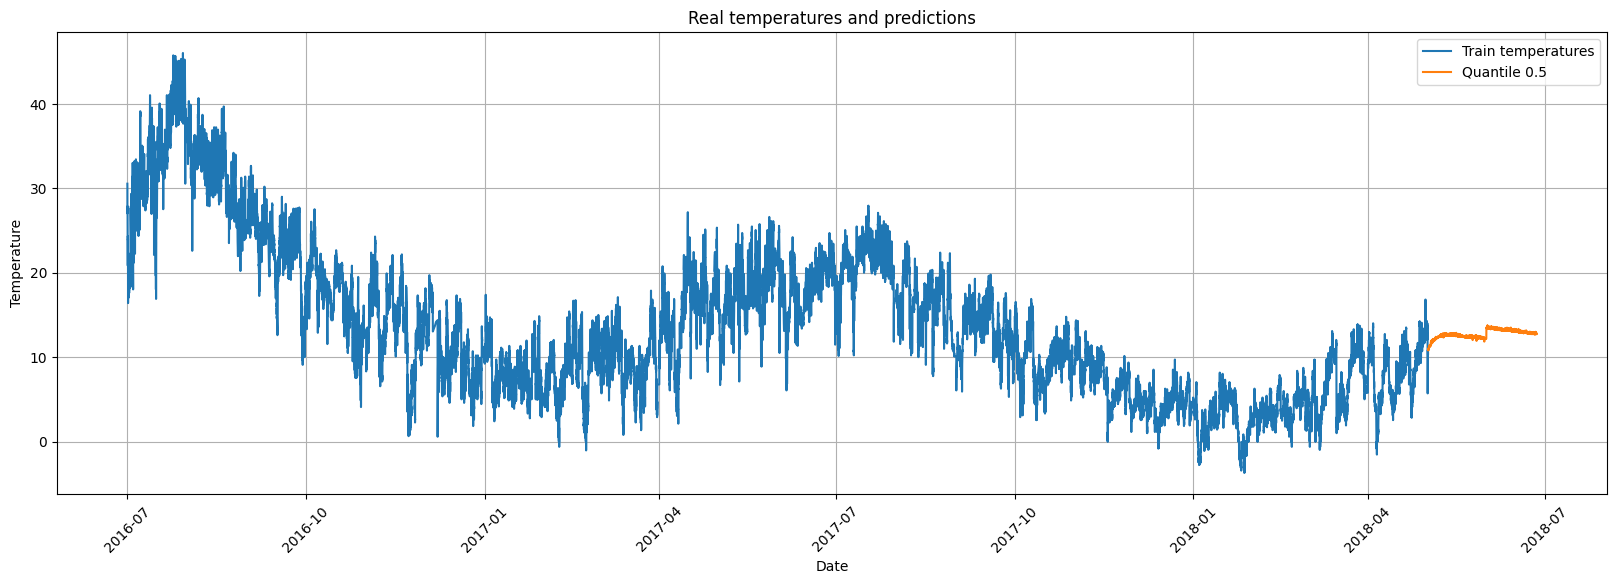

In [206]:
plt.figure(figsize=(20, 6))

sns.lineplot(data=train, x=train.index, y='Temperature', label='Train temperatures')

#for column in predictions.columns:
    #sns.lineplot(data=predictions, x=predictions.index, y=column, label=column)

sns.lineplot(data=predictions, x=predictions.index, y=predictions[0.5], label=f'Quantile {predictions.columns[10]}')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Real temperatures and predictions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## SARIMA
Score obtenido en Kaggle: 2.6715

Vamos a reutilizar el orden obtenido en el AutoARIMA realizado para el modelo ARIMA. Como pudimos observar en las gráfica de estacionalidad, nuestros datos tienen un componente estacional con una frecuencia de 12 meses, por lo que vamos a establecer un seasonality de 12

In [234]:
model = SARIMAX(order=(1,0,3), seasonal_order=(1,0,1,12))

In [235]:
train_no_temp = train.drop("Temperature", axis=1)

model.fit(train["Temperature"], train_no_temp)

SARIMAX(order=(1, 0, 3), seasonal_order=(1, 0, 1, 12))

In [236]:
test["Temperature"] = 0

X_test = test.drop("Temperature", axis=1)
y_test = test.index

predictions = model.predict_quantiles(fh=y_test, X=X_test, alpha=QUANTILE_LEVELS)
predictions.head()

Temperature                                              \
                          0.025      0.050      0.100      0.150      0.200   
2018-05-02 00:00:00    9.976146  10.121028  10.288067  10.400767  10.490338   
2018-05-02 00:15:00    9.522047   9.738702   9.988490  10.157021  10.290964   
2018-05-02 00:30:00    9.228876   9.496292   9.804606  10.012625  10.177951   
2018-05-02 00:45:00    8.958295   9.268338   9.625798   9.866975  10.058654   
2018-05-02 01:00:00    8.728081   9.075344   9.475717   9.745847   9.960538   

                                                                            \
                         0.250      0.300      0.350      0.400      0.450   
2018-05-02 00:00:00  10.567181  10.636189  10.700135  10.760814  10.819521   
2018-05-02 00:15:00  10.405876  10.509070  10.604694  10.695433  10.783223   
2018-05-02 00:30:00  10.319786  10.447158  10.565188  10.677186  10.785546   
2018-05-02 00:45:00  10.223098  10.370774  10.507618  10.637469  10.763101   
2018-05-02 01:00:00  10.144723  10.310127  10.463399  10.608838  10.749553   

                     ...                                              \
                     ...      0.550      0.600      0.650      0.700   
2018-05-02 00:00:00  ...  10.935074  10.993782  11.054460  11.118407   
2018-05-02 00:15:00  ...  10.956020  11.043810  11.134549  11.230173   
2018-05-02 00:30:00  ...  10.998829  11.107189  11.219187  11.337217   
2018-05-02 00:45:00  ...  11.010383  11.136015  11.265866  11.402710   
2018-05-02 01:00:00  ...  11.026520  11.167235  11.312675  11.465946   

                                                                            \
                         0.750      0.800      0.850      0.900      0.950   
2018-05-02 00:00:00  11.187415  11.264258  11.353829  11.466529  11.633568   
2018-05-02 00:15:00  11.333367  11.448279  11.582222  11.750753  12.000542   
2018-05-02 00:30:00  11.464589  11.606424  11.771751  11.979769  12.288083   
2018-05-02 00:45:00  11.550386  11.714830  11.906509  12.147686  12.505146   
2018-05-02 01:00:00  11.631351  11.815536  12.030226  12.300356  12.700729   

                                
                         0.975  
2018-05-02 00:00:00  11.778449  
2018-05-02 00:15:00  12.217196  
2018-05-02 00:30:00  12.555499  
2018-05-02 00:45:00  12.815189  
2018-05-02 01:00:00  13.047993  

[5 rows x 21 columns]

In [237]:
predictions.columns

MultiIndex([('Temperature', 0.025),
            ('Temperature',  0.05),
            ('Temperature',   0.1),
            ('Temperature',  0.15),
            ('Temperature',   0.2),
            ('Temperature',  0.25),
            ('Temperature',   0.3),
            ('Temperature',  0.35),
            ('Temperature',   0.4),
            ('Temperature',  0.45),
            ('Temperature',   0.5),
            ('Temperature',  0.55),
            ('Temperature',   0.6),
            ('Temperature',  0.65),
            ('Temperature',   0.7),
            ('Temperature',  0.75),
            ('Temperature',   0.8),
            ('Temperature',  0.85),
            ('Temperature',   0.9),
            ('Temperature',  0.95),
            ('Temperature', 0.975)],
           )

In [238]:
quantiles_columns = predictions.columns.droplevel(level=0)

predictions.columns = quantiles_columns
predictions.columns

Index([0.025,  0.05,   0.1,  0.15,   0.2,  0.25,   0.3,  0.35,   0.4,  0.45,
         0.5,  0.55,   0.6,  0.65,   0.7,  0.75,   0.8,  0.85,   0.9,  0.95,
       0.975],
      dtype='float64')

In [239]:
predictions["id"] = template["id"].values
id_column = predictions.pop('id')

predictions.insert(0, 'id', id_column)

predictions = predictions.reset_index(drop=True)
predictions.head()

,id,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975
0,64320,9.976146,10.121028,10.288067,10.400767,10.490338,10.567181,10.636189,10.700135,10.760814,...,10.935074,10.993782,11.054460,11.118407,11.187415,11.264258,11.353829,11.466529,11.633568,11.778449
1,64321,9.522047,9.738702,9.988490,10.157021,10.290964,10.405876,10.509070,10.604694,10.695433,...,10.956020,11.043810,11.134549,11.230173,11.333367,11.448279,11.582222,11.750753,12.000542,12.217196
2,64322,9.228876,9.496292,9.804606,10.012625,10.177951,10.319786,10.447158,10.565188,10.677186,...,10.998829,11.107189,11.219187,11.337217,11.464589,11.606424,11.771751,11.979769,12.288083,12.555499
3,64323,8.958295,9.268338,9.625798,9.866975,10.058654,10.223098,10.370774,10.507618,10.637469,...,11.010383,11.136015,11.265866,11.402710,11.550386,11.714830,11.906509,12.147686,12.505146,12.815189
4,64324,8.728081,9.075344,9.475717,9.745847,9.960538,10.144723,10.310127,10.463399,10.608838,...,11.026520,11.167235,11.312675,11.465946,11.631351,11.815536,12.030226,12.300356,12.700729,13.047993


In [240]:
predictions.to_csv("SARIMA_submission.csv", index=False)

Vamos a volver a formatear el dataframe pero esta vez para poder mostrarl los resultados en una gráfica

In [241]:
predictions.index = test.index
predictions = predictions.drop('id', axis=1)
predictions

,0.025,0.050,0.100,0.150,0.200,0.250,0.300,0.350,0.400,0.450,...,0.550,0.600,0.650,0.700,0.750,0.800,0.850,0.900,0.950,0.975
date,,,,,,,,,,,,,,,,,,,,,
2018-05-02 00:00:00,9.976146,10.121028,10.288067,10.400767,10.490338,10.567181,10.636189,10.700135,10.760814,10.819521,...,10.935074,10.993782,11.054460,11.118407,11.187415,11.264258,11.353829,11.466529,11.633568,11.778449
2018-05-02 00:15:00,9.522047,9.738702,9.988490,10.157021,10.290964,10.405876,10.509070,10.604694,10.695433,10.783223,...,10.956020,11.043810,11.134549,11.230173,11.333367,11.448279,11.582222,11.750753,12.000542,12.217196
2018-05-02 00:30:00,9.228876,9.496292,9.804606,10.012625,10.177951,10.319786,10.447158,10.565188,10.677186,10.785546,...,10.998829,11.107189,11.219187,11.337217,11.464589,11.606424,11.771751,11.979769,12.288083,12.555499
2018-05-02 00:45:00,8.958295,9.268338,9.625798,9.866975,10.058654,10.223098,10.370774,10.507618,10.637469,10.763101,...,11.010383,11.136015,11.265866,11.402710,11.550386,11.714830,11.906509,12.147686,12.505146,12.815189
2018-05-02 01:00:00,8.728081,9.075344,9.475717,9.745847,9.960538,10.144723,10.310127,10.463399,10.608838,10.749553,...,11.026520,11.167235,11.312675,11.465946,11.631351,11.815536,12.030226,12.300356,12.700729,13.047993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-26 18:45:00,-7.531463,-4.336151,-0.652160,1.833412,3.808865,5.503628,7.025577,8.435890,9.774139,11.068911,...,13.617398,14.912169,16.250418,17.660731,19.182681,20.877444,22.852897,25.338468,29.022459,32.217772
2018-06-26 19:00:00,-7.525297,-4.329985,-0.645994,1.839577,3.815031,5.509794,7.031743,8.442056,9.780305,11.075077,...,13.623564,14.918335,16.256584,17.666897,19.188847,20.883610,22.859063,25.344634,29.028625,32.223938
2018-06-26 19:15:00,-7.537193,-4.341880,-0.657890,1.827682,3.803135,5.497898,7.019847,8.430160,9.768409,11.063181,...,13.611668,14.906439,16.244688,17.655002,19.176951,20.871714,22.847167,25.332738,29.016729,32.212042


Mostramos la mediana de la predicción

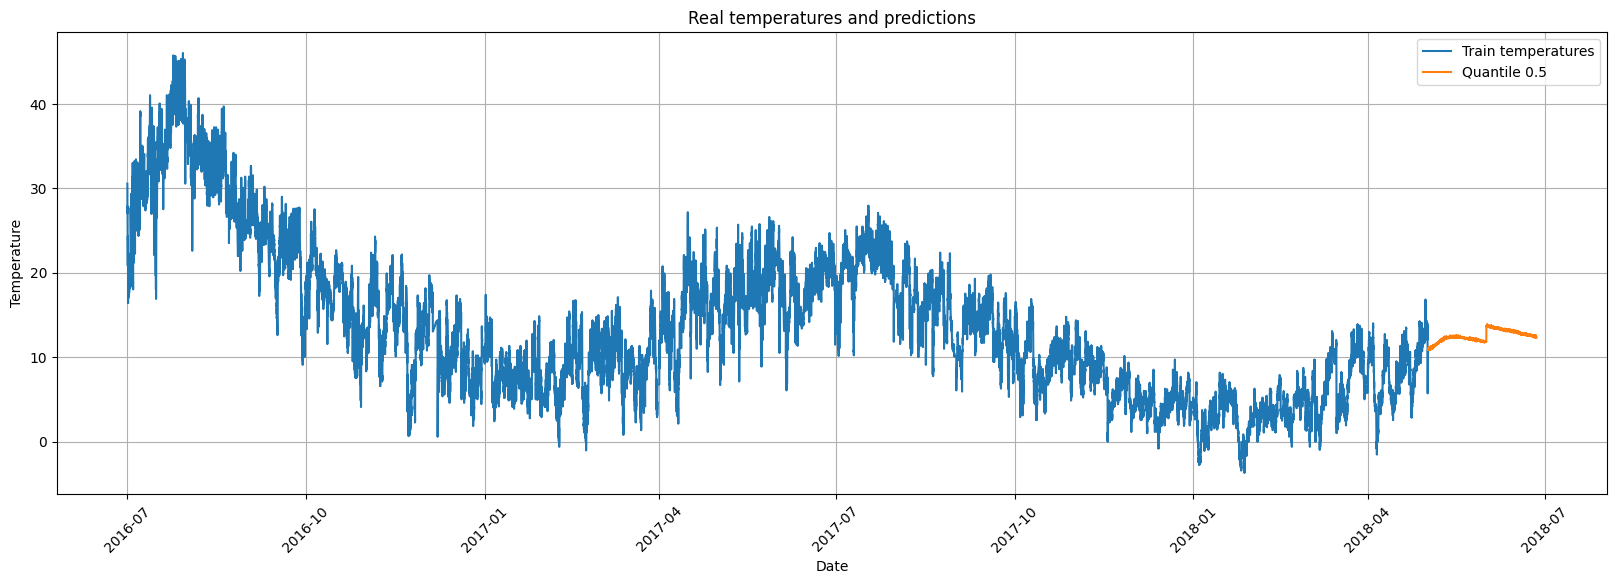

In [242]:
plt.figure(figsize=(20, 6))

sns.lineplot(data=train, x=train.index, y='Temperature', label='Train temperatures')

#for column in predictions.columns:
    #sns.lineplot(data=predictions, x=predictions.index, y=column, label=column)

sns.lineplot(data=predictions, x=predictions.index, y=predictions[0.5], label=f'Quantile {predictions.columns[10]}')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Real temperatures and predictions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

Dado los resultados obtenidos al subir las predicciones obtenidas a Kaggle, vemos que el mejor modelo es el ARIMA, seguido de XGBoost Regressor, SARIMA y por último el Random Forest Regressor